# Training and evaluation with the built-in methods

## 0. Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("The version of Tensorflow: ".format(tf.__version__))

The version of Tensorflow: 


## 1. Introduction

## 2. API overview: a first end-to-end example

In [2]:
# Let's consider the following model (here, we build in with the Functional API, 
# but it could be a Sequential model or a subclassed model as well):

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
# We'll use MNIST data for this example.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [4]:
# We specify the training configuration (optimizer, loss, metrics):

model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [5]:
# We call fit(), which will train the model by slicing the data into "batches" of size "batch_size", 
# and repeatedly iterating over the entire dataset for a given number of "epochs".

print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 4s 4ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.2043 - val_sparse_categorical_accuracy: 0.9430
Epoch 2/2
782/782 [==============================] - 3s 3ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1451 - val_sparse_categorical_accuracy: 0.9574


In [6]:
# The returned "history" object holds a record of the loss values and metric values during training:

history.history

{'loss': [0.33571407198905945, 0.155551478266716],
 'sparse_categorical_accuracy': [0.9049199819564819, 0.953000009059906],
 'val_loss': [0.20427437126636505, 0.14510458707809448],
 'val_sparse_categorical_accuracy': [0.9430000185966492, 0.9574000239372253]}

In [7]:
# We evaluate the model on the test data via evaluate():

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 1ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.9529
test loss, test acc: [0.15639930963516235, 0.9528999924659729]
Generate predictions for 3 samples
predictions shape: (3, 10)


## 3. The compile() method: specifying a loss, metrics, and an optimizer

In [8]:
# To train a model with fit(), you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.

# You pass these to the model as arguments to the compile() method:

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [9]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [10]:
# For later reuse, let's put our model definition and compile step in functions;
# we will call them several times across different examples in this guide.

def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

### i. Many built-in optimizers, losses, and metrics are available

### ii. Custom losses

In [11]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.0290


In [12]:
# Here's how you would do it:

class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.0493


### iii. Custom metrics

In [13]:
# Here's a simple example showing how to implement a CategoricalTruePositives metric, 
# that counts how many samples were correctly classified as belonging to a given class:

class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 3s 3ms/step - loss: 0.5653 - categorical_true_positives: 22099.7995
Epoch 2/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1747 - categorical_true_positives: 23808.0549
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1161 - categorical_true_positives: 24207.2273


### iv. Handling losses and metrics that don't fit the standard signature

In [14]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 3ms/step - loss: 3.6212


In [15]:
# You can do the same for logging metric values, using add_metric():

class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 3ms/step - loss: 0.5647 - std_of_activation: 0.9332


In [16]:
# Here's a simple example:

inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 3ms/step - loss: 3.4551 - std_of_activation: 0.0019


In [17]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)

In [18]:
# You can use it in a model with two inputs (input data & targets), compiled without a loss argument, like this:

import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 218ms/step - loss: 0.9083 - binary_accuracy: 0.0000e+00


### v. Automatically setting apart a validation holdout set

In [20]:
# Note that you can only use validation_split when training with NumPy data.

model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 2s 3ms/step - loss: 0.6216 - sparse_categorical_accuracy: 0.8304 - val_loss: 0.2422 - val_sparse_categorical_accuracy: 0.9253


## 4. Training & evaluation from tf.data Datasets

In [21]:
# You can pass a Dataset instance directly to the methods fit(), evaluate(), and predict():

model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 3s 3ms/step - loss: 0.5582 - sparse_categorical_accuracy: 0.8499
Epoch 2/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.9514
Epoch 3/3
782/782 [==============================] - 2s 3ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9654
Evaluate
157/157 [==============================] - 0s 1ms/step - loss: 0.1151 - sparse_categorical_accuracy: 0.9665


{'loss': 0.11511613428592682,
 'sparse_categorical_accuracy': 0.9664999842643738}

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 1s 3ms/step - loss: 1.2085 - sparse_categorical_accuracy: 0.6633
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3849 - sparse_categorical_accuracy: 0.8877
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3498 - sparse_categorical_accuracy: 0.8953


### Using a validation dataset

In [23]:
# You can pass a Dataset instance as the validation_data argument in fit():

model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 3s 4ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.2124 - val_sparse_categorical_accuracy: 0.9376


In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 3s 3ms/step - loss: 0.5703 - sparse_categorical_accuracy: 0.8445 - val_loss: 0.2661 - val_sparse_categorical_accuracy: 0.9281


## 5. Other input formats supported

## 6. Using a keras.utils.Sequence object as input

In [ ]:
# Here's a quick example:

from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)

## 7. Using sample weighting and class weighting

### i. Class weights

In [28]:
# Here's a NumPy example where we use class weights or sample weights to give 
# more importance to the correct classification of class #5 (which is the digit "5" in the MNIST dataset).

import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 3s 3ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.8366


### ii. Sample weights

In [29]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 3s 3ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.8323


In [30]:
# Here's a matching Dataset example:

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 3s 3ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.8402


## 8. Passing data to multi-input, multi-output models

In [31]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

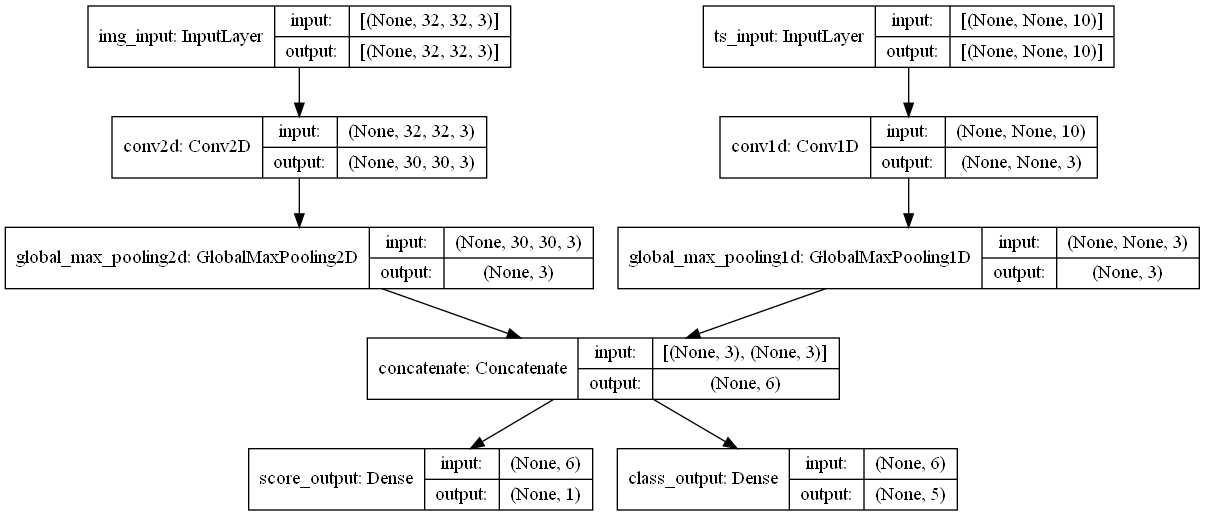

In [32]:
# Let's plot this model, so you can clearly see what we're doing here 
# (note that the shapes shown in the plot are batch shapes, rather than per-sample shapes).

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [33]:
# Likewise for metrics:

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

In [34]:
# Since we gave names to our output layers, we could also specify per-output losses and metrics via a dict:

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

In [35]:
# It's possible to give different weights to different output-specific losses 
# (for instance, one might wish to privilege the "score" loss in our example, by giving to 2x the importance of the class loss), 
# using the loss_weights argument:

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

In [36]:
# You could also chose not to compute a loss for certain outputs, if these outputs meant for prediction but not for training:

# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

In [37]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 7ms/step - loss: 18.2324 - score_output_loss: 0.3146 - class_output_loss: 17.9178


In [38]:
# Here's the Dataset use case: similarly as what we did for NumPy arrays, the Dataset should return a tuple of dicts.

train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 0s 64ms/step - loss: 17.9810 - score_output_loss: 0.2322 - class_output_loss: 17.7488


## 9. Using callbacks

In [39]:
# Callbacks can be passed as a list to your call to fit():

model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6193 - sparse_categorical_accuracy: 0.8281 - val_loss: 0.2226 - val_sparse_categorical_accuracy: 0.9329
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.1816 - val_sparse_categorical_accuracy: 0.9449
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.1584 - val_sparse_categorical_accuracy: 0.9531
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.1471 - val_sparse_categorical_accuracy: 0.9560
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.1371 - val_sparse_categorical_accuracy: 0.9619
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.0659 - sparse_categorica

### i. Many built-in callbacks are available

### ii. Writing your own callback

In [40]:
# Here's a simple example saving a list of per-batch loss values during training:

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs):
    self.per_batch_losses = []

  def on_batch_end(self, batch, logs):
    self.per_batch_losses.append(logs.get("loss"))

## 10. Checkpointing models

In [41]:
# The easiest way to achieve this is with the ModelCheckpoint callback:

model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
625/625 [==============================] - 2s 3ms/step - loss: 0.6097 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.2524 - val_sparse_categorical_accuracy: 0.9226

Epoch 00001: val_loss improved from inf to 0.25242, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1\assets
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.1694 - val_sparse_categorical_accuracy: 0.9481

Epoch 00002: val_loss improved from 0.25242 to 0.16939, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2\assets


In [44]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Restoring from .//mymodel_2
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.9597


## 11. Using learning rate schedules

### i. Passing a schedule to an optimizer

In [45]:
# You can easily use a static learning rate decay schedule by 
# passing a schedule object as the learning_rate argument in your optimizer:

initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

### ii. Using callbacks to implement a dynamic learning rate schedule

## 12. Visualizing loss and metrics during training

### Using the TensorBoard callback

In [46]:
# The easiest way to use TensorBoard with a Keras model and the fit method is the TensorBoard callback.

# In the simplest case, just specify where you want the callback to write logs, and you're good to go:


keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

# reference

### https://tensorflow.google.cn/guide/keras/train_and_evaluate